# Banana Game

## Solution

### Agent

The learning agent is double, deep q-network agent, that uses prioritised replay. An outline of this agent is the following:

 * There are two networks: one used for control, and one used for policy improvement (target).
 * Each step of an episode, an epsilon-greedy policy is use for control of the agent. This epsilon-greedy policy is based on a deep neural network that approximates the action value for each state action pair.
 * At the end of each step, the s, a, s, r tuple is added to the replay buffer along with a priority, which is calculated as the magnitude of the difference between the control and the target network, i.e., the error in boostrapping Bellman eqn for the current state-action pair. Only a fixed number of experiences are retained in the buffer and the ones with the smallest priority are dropped first.
 * Periodically, the control network is update with by trying to minimise the loss in the Bellman equations for a sample of experiences from the replay buffer. The probabilities of these samples are proportional to their priorities. At this time the target network is moved toward the control network with an exponential filter, controlled by the rate tau. The contribution of each experience to the loss must be adjusted however to compensate for the non-uniform probability of selection. See Agent.learn for the details.
 * At the end of the episode the value of epsilon is decreased by a constant factor.
 
All of the hyper-parameters were chosen based on what worked well in the simpler taxi environment.
 
### Q Network

The Q network has an input layer that consists of the continuous state variables. The output layer consists of the state-action values for each of the discrete choices of action. The greedy policy uses the action corresponding to the max of the output layer as its action. There are two hidden layers consisting of 64-unit linear function and a ELU activation.


## Further work

 * Little effort was to innovate on the q-network. More sophisticated techniques could be used there, e.g., dropout, batch normalisation, adding a regularisation loss.
 * The original prioritised replay buffer (https://arxiv.org/pdf/1511.05952.pdf) introduces two more hyper-parameters to control the weighting by priority. These were not used and could be introduced. However adding more hyper-parameters means more tuning is required and there is greater possibility of overfitting.

In [5]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML

from reacher_env import make_reacher_env, reacher_episode
from run import train
from agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
env = make_reacher_env()
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset()[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

agent = Agent(
    device,
    state_size,
    action_size,
    buffer_size=int(1e6),
    batch_size=64,
    actor_learning_rate=1e-4,
    critic_learning_rate=1e-3,
    discount_rate=0.99,
    tau=1e-3,
    steps_per_update=5,
    weight_decay=0.00,
    noise_decay=0.999,
    noise_max=0.2,
    dropout_p=0.2,
    n_agents=20
)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
scores = train(env, agent, brain_name, max_eps=int(2e5), min_score=33.0)

100 - 0.87
200 - 2.22
600 - 25.97
700 - 34.35


Plot of scores, and mean scores over 100 episodes:

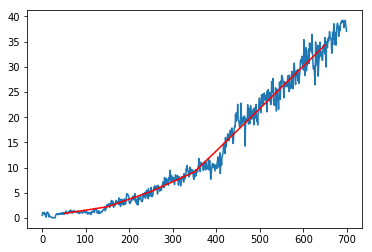

In [4]:
avg_scores = np.array(scores).reshape(-1, 100).mean(axis=1)
plt.plot(scores)
plt.plot(np.arange(avg_scores.shape[0]) * 100 + 50, avg_scores, 'r-')

In [4]:
agent.restore('best')
agent.noise.sigma = 0.0

reacher_episode(env, agent, env.brain_names[0], train=False)

38.38099914211788

In [ ]:
%%HTML
<video width="320" height="240" controls>
  <source src="./recording.mov" type="video/mp4">
</video>